In [1]:
%load_ext autoreload
%autoreload 2

import rare_traffic_sign_solution as rtss
import lib

import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.datasets import ImageFolder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from math import floor, ceil
from sklearn.model_selection import train_test_split

import json
import shutil
import requests
import functools
import pathlib
from pathlib import Path
import shutil
from tqdm.notebook import tqdm
import os
from collections import defaultdict

from IPython.display import clear_output

matplotlib.rcParams['figure.figsize'] = (20, 1)

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

In [2]:
model = rtss.ModelWithHead()
model.load_nn('/home/alexkkir/cv-hw10-road-signs/improved_features_model.pth')
clear_output()

In [3]:
dataset = rtss.DatasetRTSD(
    ['synthetic_3', 'cropped-train'],
    'classes.json',
)

classes_per_batch = 32
elems_per_class = 4

sampler_1 = rtss.CustomBatchSampler(dataset, classes_per_batch=classes_per_batch, elems_per_class=elems_per_class, max_iters=1)
train_loader = DataLoader(dataset, batch_sampler=sampler_1, num_workers=16)

In [4]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices=[0],
)
trainer.validate(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Validation: 0it [00:00, ?it/s]

/home/alexkkir/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
2022-11-25 03:49:26.436398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 03:49:26.709443: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-25 03:49:27.458878: W tensorflow/compil

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc                    1.0
        val_loss            0.4543724060058594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.4543724060058594, 'val_acc': 1.0}]

In [5]:
class FeaturesLoss(torch.nn.Module):
    """
    Класс для вычисления loss-функции на признаки предпоследнего слоя нейросети.
    """
    def __init__(self, margin: float) -> None:
        super(FeaturesLoss, self).__init__()
        # YOUR CODE HERE
        self.margin = margin

    def forward(self, f, y):
        n = len(y)
        loss_1, loss_2, cnt_1, cnt_2 = 0, 0, 0, 0
        for i in range(n):
            for j in range(n):
                norm = torch.norm(f[i] - f[j])
                if y[i] == y[j]:
                    loss_1 += norm ** 2
                    cnt_1 += 1
                else:
                    loss_2 += max(self.margin - norm, 0) ** 2
                    cnt_2 += 1
        return loss_1 / (2 * cnt_1) + loss_2 / (2 * cnt_2)

In [6]:
batch = next(iter(train_loader))

In [7]:
dataset = rtss.DatasetRTSD(
    ['synthetic_3'],
    'classes.json',
    use_augmentations=False
)

classes_file = 'classes.json'
with open(classes_file, "r") as fr:
    classes_info = json.load(fr)
class_name_to_type = {v['id']: v['type'] for k, v in classes_info.items()}

In [8]:
device = torch.device('cuda:0')
index_sampler = rtss.IndexSampler(dataset, 10)
knn_train = DataLoader(dataset, sampler=index_sampler, batch_size = 16, num_workers=16)

model.to(device)
model.eval()

X_train = []
Y_train = []

for batch in knn_train:
    labels = batch[2].numpy()
    images = batch[0].to(device)
    features = model(images).detach().cpu()
    features = features.reshape(features.size(0), -1).numpy()
    features = features.astype('float16')
    features /= np.linalg.norm(features, axis=1)[:, None]
    labels = labels.astype('uint8')
    for i in range(len(features)):
        X_train.append(features[i])
        Y_train.append(labels[i])

In [9]:
knn = KNeighborsClassifier(
    n_neighbors=3,
    weights='distance',
    metric='euclidean'
)
knn.fit(X_train, Y_train)
import pickle as pkl
with open('knn_model.bin', 'wb') as f:
    pkl.dump(X_train, f)    
    pkl.dump(Y_train, f)
! ls knn_model.bin -lh

-rw-rw-r-- 1 alexkkir alexkkir 4,1M ноя 25 03:49 knn_model.bin


In [10]:
dataset_test = rtss.TestData('smalltest', 'classes.json', 'smalltest_annotations.csv', return_class_name=False)
knn_test = DataLoader(dataset_test, batch_size=16, num_workers=16)

n_exps = 1
n_neighbours = 6

all = np.zeros((n_exps, n_neighbours))
rare = np.zeros((n_exps, n_neighbours))
freq = np.zeros((n_exps, n_neighbours))

for exp in tqdm(range(n_exps)):
    X_test = []
    Y_test = []

    for batch in knn_test:
        labels = batch[2].numpy()
        images = batch[0].to(device)
        features = model(images).detach().cpu()
        features = features.reshape(features.size(0), -1).numpy()
        features = features.astype('float16')
        features /= np.linalg.norm(features, axis=1)[:, None]
        labels = labels.astype('uint8')
        for i in range(len(features)):
            X_test.append(features[i])
            Y_test.append(labels[i])

    for k in (range(1, 6)):
        knn.n_neighbors = k
        pred_test = knn.predict(X_test)
        all[exp][k] = (rtss.calc_metric(Y_test, pred_test, 'all', class_name_to_type))
        rare[exp][k] = (rtss.calc_metric(Y_test, pred_test, 'rare', class_name_to_type))
        freq[exp][k] = (rtss.calc_metric(Y_test, pred_test, 'freq', class_name_to_type))

all = all[:, 1:]
rare = rare[:, 1:]
freq = freq[:, 1:] 

  0%|          | 0/1 [00:00<?, ?it/s]

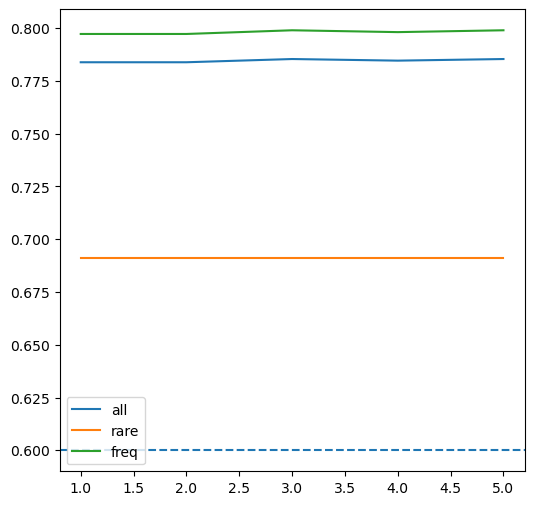

In [11]:
plt.figure(figsize=(6, 6))
plt.plot(range(1, n_neighbours), all.mean(axis=0), label='all')
plt.plot(range(1, n_neighbours), rare.mean(axis=0), label='rare')
plt.plot(range(1, n_neighbours), freq.mean(axis=0), label='freq')
plt.axhline(0.6, ls='--')
plt.legend()
plt.show()

In [12]:
rare

array([[0.69090909, 0.69090909, 0.69090909, 0.69090909, 0.69090909]])

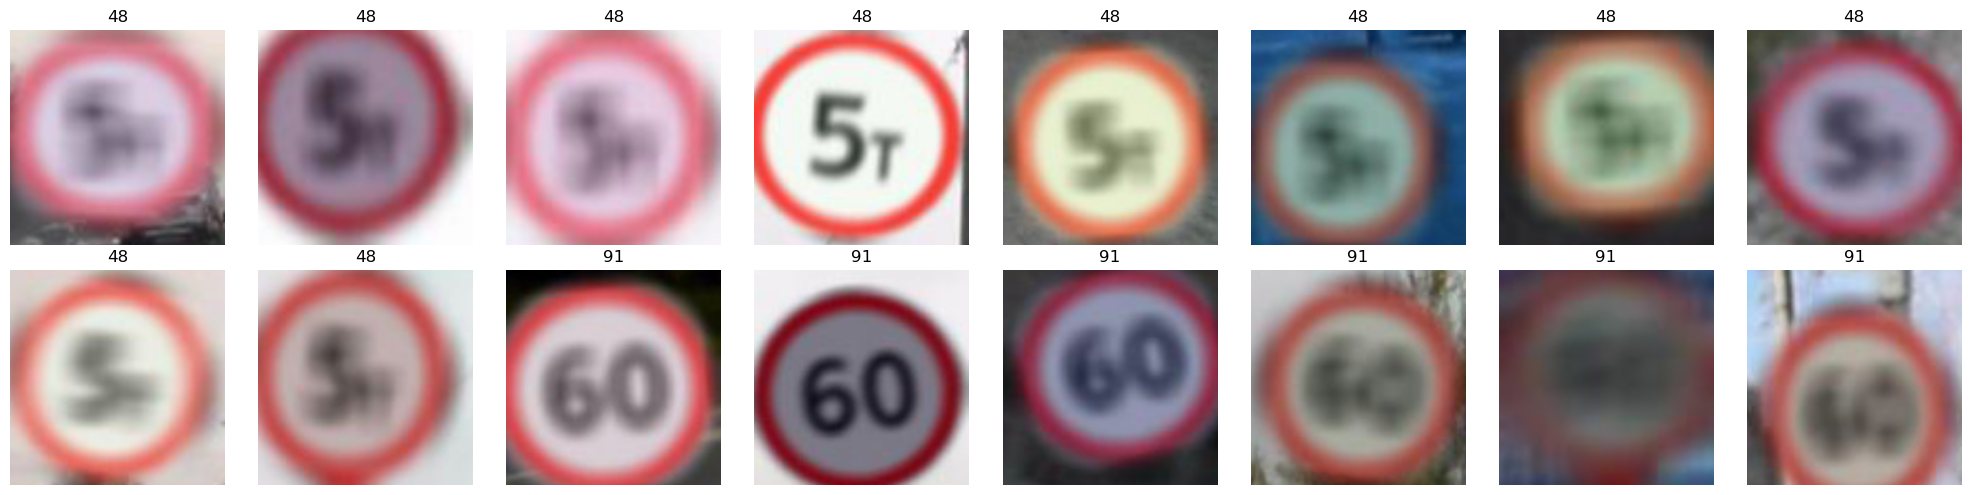

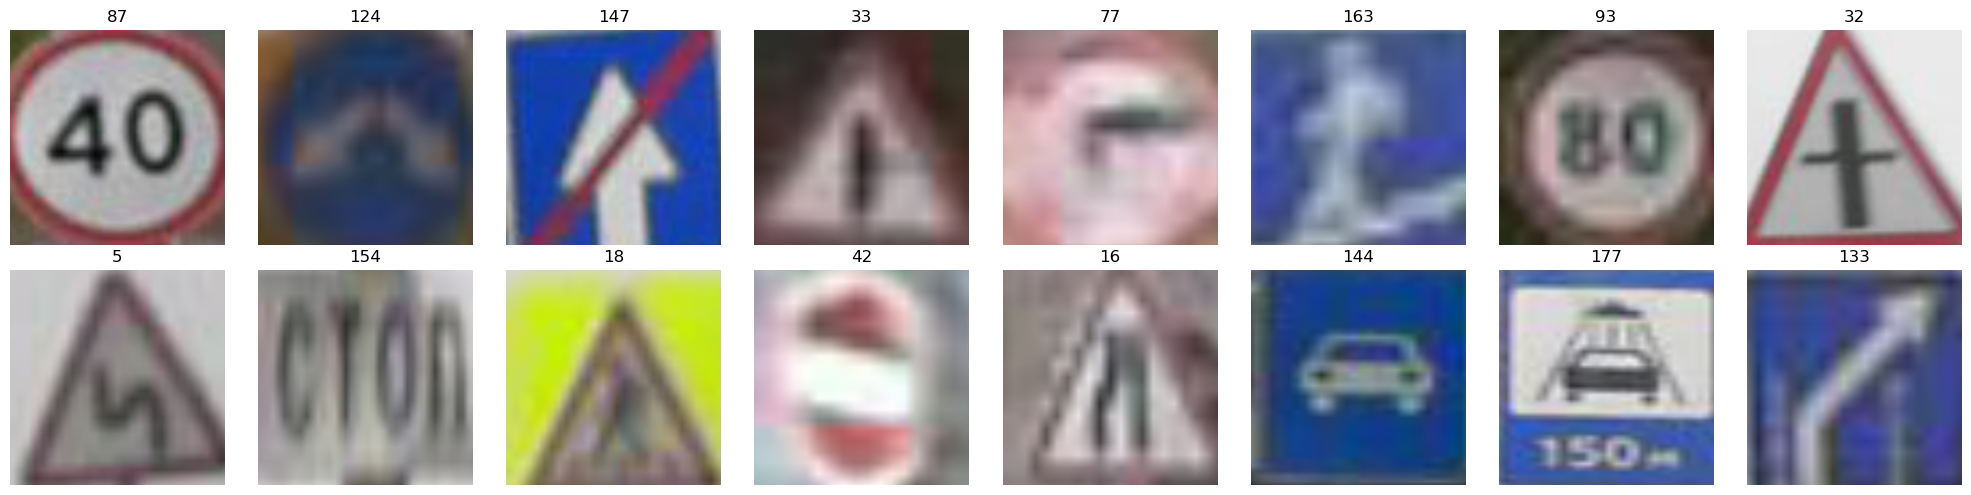

In [13]:
lib.display_loader(knn_train)
lib.display_loader(knn_test)